In [ ]:
# Проверка среды выполнения СoLab/Local
oncolab = 'google.colab' in str(get_ipython())
if oncolab:
  print('Running on CoLab')
else:
  print('Not running on CoLab')

In [2]:
!pip install uproot3 awkward particle scikit-learn 'iminuit<2' probfit cupy-cuda110
!pip install gputil psutil humanize
#install cupy if CUDA SDK is present
![ -h /usr/local/cuda ] && pip install cupy-cuda$(ls -l /usr/local/cuda | sed -rn 's/.*cuda-([0-9]+).([0-9])/\1\2/p')

In [3]:
# memory footprint support libraries/code
import os, psutil, humanize
import GPUtil as GPU
def printrss():
  process = psutil.Process(os.getpid())
  !cat /proc/cpuinfo | fgrep "model name" | sed -r "s/^model name\s+:\s+(.+)/\1/"
  print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
  !df
  try:
    GPUs = GPU.getGPUs()
    gpu = GPUs[0]
    print("GPU", gpu.name, "| driver", gpu.driver)
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
  except:
    print("No GPU provided")
    gpu = None
  return gpu

gpu = printrss()

Intel(R) Xeon(R) CPU @ 2.30GHz
Intel(R) Xeon(R) CPU @ 2.30GHz
Gen RAM Free: 12.7 GB  | Proc size: 117.9 MB
Filesystem     1K-blocks     Used Available Use% Mounted on
overlay         71670904 41185476  30469044  58% /
tmpfs              65536        0     65536   0% /dev
tmpfs            6651460        0   6651460   0% /sys/fs/cgroup
shm              6029312        0   6029312   0% /dev/shm
tmpfs            6651460       40   6651420   1% /var/colab
/dev/sda1       79368748 44588480  34763884  57% /opt/bin/.nvidia
tmpfs            6651460        0   6651460   0% /proc/acpi
tmpfs            6651460        0   6651460   0% /proc/scsi
tmpfs            6651460        0   6651460   0% /sys/firmware
drive           71670904 42725316  28945588  60% /mntDrive
GPU Tesla K80 | driver 460.32.03
GPU RAM Free: 11441MB | Used: 0MB | Util   0% | Total 11441MB


In [4]:
#@title Настройка выполнения кода
mode = "beta" #@param ["beta", "class"]

verbose = False #@param {type:"boolean"}

updateEDF = False #@param {type:"boolean"}

updateNNdata = False #@param {type:"boolean"}

useCuPy = True #@param {type:"boolean"}

# отключение использования CuPy, если GPU не выделен
if gpu is None:
  useCuPy = False

# Частота темновых шумов на 1 кв. мм. Если noisefreqpersqmm==0, то шум не моделируется.
noisefreqpersqmm =  1000000#@param {type:"number"}

#@title Настройка модели нейросети
nBins = (5, 20, 5) #@param {type:"raw"}

# длительность временных ворот для отбора срабатываний, нс
timeGate = 5  #@param {type:"number"}

In [5]:
restoreModel = False #@param {type:"boolean"}

fitModel = True #@param {type:"boolean"}

maxepochs = 300 #@param {type:"integer"}

batchSize = 128 #@param {type:"integer"}

# конфигурация скрытых слоев нейросети
hlayers = (200, 100, 50, 20) #@param {type:"raw"}


In [6]:
import glob
if oncolab:
  from google.colab import drive 
  drive.mount('/mntDrive')  # смонтировать диск в папке «mntDrive»   
  datadir = '/mntDrive/My Drive/FARICH/Reconstruction/NN/data'
else:
  datadirs = [r'C:\Users\skono\Google Диск (skononov@nsu.ru)\FARICH\Reconstruction\NN\data', \
              r'D:\skono\Google Диск НГУ\FARICH\Reconstruction\NN\data', \
              r'C:\Users\skono\Google Диск НГУ\FARICH\Reconstruction\NN\data']
  datadir = None
  for dir in datadirs:
    if os.access(dir, os.R_OK):
      datadir = dir
      os.chdir(datadir)
      break

betatrain_filenames = [os.path.join(datadir, 'pi-pi-', 'rndm', fn) for fn in ['farichsim_pi-pi-_45-360deg_1200.0k_ideal_2020-12-24_rndm.root', 'farichsim_pi-pi-_45-360deg_120.0k_ideal_2020-12-07_rndm.root']]
#betatrain_filenames = [os.path.join(datadir, 'pi-pi-', 'rndm', fn) for fn in ['farichsim_pi-pi-_45-360deg_120.0k_ideal_2020-12-07_rndm.root']]
class_filenames = [os.path.join(datadir, 'mu-pi-', 'rndm', 'farichsim_mu-pi-_45-360deg_120.0k_ideal_2020-12-07_rndm.root'),]

rootFilenameMap = {'beta': betatrain_filenames, 'class': class_filenames}

Drive already mounted at /mntDrive; to attempt to forcibly remount, call drive.mount("/mntDrive", force_remount=True).


In [7]:
import sys
srcdir = os.path.dirname(datadir)
if srcdir not in sys.path:
  sys.path.append(srcdir)
from farichnnlib import *

In [8]:
strategy = initcompstrategy(oncolab)

Could not set TPU distribution strategy!
Please provide a TPU Name to connect to.
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Physical devices cannot be modified after being initialized
2 physical devices: /physical_device:CPU:0 /physical_device:GPU:0
1 physical GPUs: /physical_device:GPU:0
0 physical TPUs: 
2 logical devices: /device:CPU:0 /device:GPU:0
1 logical GPUs: /device:GPU:0
0 logical TPUs: 


In [ ]:
show_uproot_tree(uproot.open(rootFilenameMap[mode][0]))

TFile: ./farichsim_pi-pi-_45-360deg_1200.0k_ideal_2020-12-24_rndm.root
  TTree: info_sim
    info_gen    /m_num_events
                 m_z_dis
    info_rad    /m_layers    /m_layers.first
                              m_layers.second
    info_pmt    /m_name
                 m_num_side_x
                 m_num_side_y
                 m_gap
                 m_size
                 m_chip_num_size
                 m_chip_pitch
                 m_chip_size
                 m_chip_offset
                 m_focal_length
                 m_trg_window
                 m_origin_pos/m_origin_pos._2
                              m_origin_pos._1
                              m_origin_pos._0
  TTree: raw_data
    event       /m_id_event
                 m_id_primary
                 m_pos_primar/m_pos_primary._2
                              m_pos_primary._1
                              m_pos_primary._0
                 m_dir_primar/m_dir_primary._2
                              m_dir_primary._1


In [ ]:
with uproot.open(rootFilenameMap[mode][0]) as file:
  idf = file[b'info_sim'].pandas.df('*', flatten=False)
for col in idf.columns:
  print(col, idf.at[0, col])

m_num_events 1200000
m_z_dis 1.0
m_layers 4
m_layers.first [1.041  1.0438 1.0468 1.05  ]
m_layers.second [9.32 8.93 8.55 8.2 ]
m_name b'SensL_ARRAYJ-30020-64P-PCB_25V'
m_num_side_x 30
m_num_side_y 30
m_gap 1.0
m_size 26.68
m_chip_num_size 8
m_chip_pitch 0.2
m_chip_size 3.16
m_chip_offset 0.0
m_focal_length 200.0
m_trg_window 20.0
m_origin_pos._2 201.0
m_origin_pos._1 0.0
m_origin_pos._0 0.0


In [9]:
edf = pd.read_hdf(datadir + os.sep + 'edf_rndm_all.h5', 'edf', 'r')

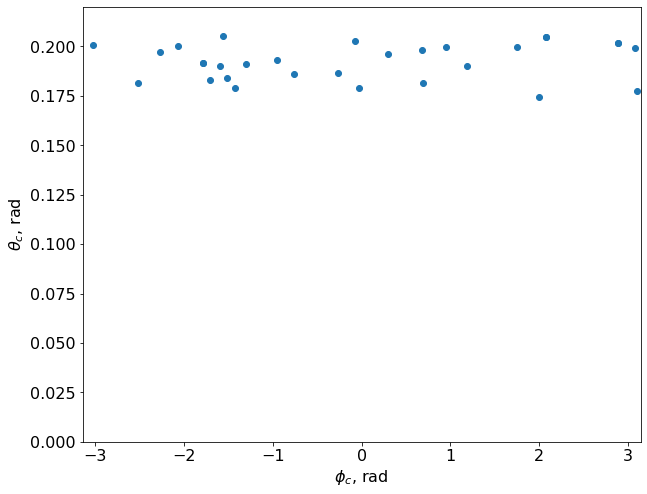

In [59]:
entry=22
theta=edf[edf.index.get_level_values('entry')==entry]['theta_c'].values
phi=edf[edf.index.get_level_values('entry')==entry]['phi_c'].values
plt.figure(figsize=(10, 8))
plt.plot(phi, theta, 'o')
plt.xlim(-pi, pi)
plt.ylim(0, 0.22)
plt.xlabel(r'$\phi_c$, rad')
plt.ylabel(r'$\theta_c$, rad')
plt.savefig(datadir + os.sep + '..' + os.sep +'pics' + os.sep + 'theta_vs_phi_oneevent.png')

In [ ]:
#plothits(rootFilenameMap[mode][0])
#fxy, ftime, ftheta = plothits(datadir + os.sep + 'beta_noise10000_tcor_edf.h5')

In [ ]:
# Копирование данных на локальный диск. Имеет смысл при вызове обработки ROOT-файлов несоклько раз.
#if oncolab:
#  for fn in rootFilenameMap[mode]:
#    !cp -uv "$fn" .
#  rootFilenameMap[mode] = ['./'+os.path.basename(fn) for fn in rootFilenameMap[mode]]

In [ ]:
# Начало работы
# Чтение ROOT-файлов, восстановление (theta_c, phi_c) и преобразование в data frame, сохраняемый в h5
#hdfilename = datadir + os.sep + f'{mode}_noise{noisefreqpersqmm:.0f}_tcor_edf.h5'
hdfilename = None
nndatafilename = datadir + os.sep + f'{mode}_phibins{nBins[0]}_thetabins{nBins[1]}_timebins{nBins[2]}_noise{noisefreqpersqmm:.0f}_gate{timeGate}ns_tcor_nndata.h5'
if not os.access(nndatafilename, os.R_OK) or updateNNdata:
  processdata(rootFilenameMap[mode], hdfilename, nndatafilename, mode, nbins=nBins, timeGate=timeGate, \
              noisefreqpersqmm=noisefreqpersqmm, updateEDF=updateEDF, verbose=verbose, usecupy=useCuPy, recorigtime=True, bin3d=True)

In [ ]:
idf = pd.read_hdf(nndatafilename, 'idf')
print(idf)
for col in idf.columns:
  print(col, idf.at[0,col])
#test_data = pd.read_hdf(nndatafilename, 'test_data', stop=10000)
#test_labels = pd.read_hdf(nndatafilename, 'test_labels', stop=10000)
#sdata = test_data['count'].stack().reset_index('bin')
#sdata.columns = ('bin', 'count')
#train_data = pd.read_hdf(nndatafilename, 'train_data')
#train_labels = pd.read_hdf(nndatafilename, 'train_labels')

       nevents  zdis  nlayers  array_size  ...     W  n_mean  n_max  nhyp
entry                                      ...                           
0      1320000   1.0        4       26.68  ...  35.0  1.0454   1.05     1

[1 rows x 16 columns]
nevents 1320000
zdis 1.0
nlayers 4
array_size 26.68
array_gap 1.0
pixel_size 3.16
pixel_gap 0.2
pixel_numx 8
nxarrays 30
nyarrays 30
distance 200.0
trg_window_ns 20.0
W 35.0
n_mean 1.0453999999999999
n_max 1.05
nhyp 1


In [ ]:
# Функции преобразования выходных значений нейросети в скорость
def beta_to_feature_n105(beta):
  beta_min = 1/1.05
  return (beta-beta_min) / (1-beta_min)

def feature_to_beta_n105(feature):
  beta_min = 1/1.05
  return beta_min + (1-beta_min) * feature

def beta_to_feature_n11(beta):
  beta_min = 1/1.1
  return (beta-beta_min) / (1-beta_min)

def feature_to_beta_n11(feature):
  beta_min = 1/1.1
  return beta_min + (1-beta_min) * feature

def beta_to_feature_n15(beta):
  beta_min = 1/1.5
  return (beta-beta_min) / (1-beta_min)

def feature_to_beta_n15(feature):
  beta_min = 1/1.5
  return beta_min + (1-beta_min) * feature

def beta_to_feature_n5(beta):
  beta_min = 1/5
  return (beta-beta_min) / (1-beta_min)            

def feature_to_beta_n5(feature):
  beta_min = 1/5
  return beta_min + (1-beta_min) * feature

def equivtrans(x):
  return x

feature_to_beta = feature_to_beta_n105
beta_to_feature = equivtrans


Loading test NN data from /mntDrive/My Drive/FARICH/Reconstruction/NN/data/beta_phibins5_thetabins20_timebins5_noise1000000_gate5ns_tcor_nndata.h5...
 263846 events for validation and testing
Using previously loaded NN data from /mntDrive/My Drive/FARICH/Reconstruction/NN/data/beta_phibins5_thetabins20_timebins5_noise1000000_gate5ns_tcor_nndata.h5.
Loading train NN data from /mntDrive/My Drive/FARICH/Reconstruction/NN/data/beta_phibins5_thetabins20_timebins5_noise1000000_gate5ns_tcor_nndata.h5...
 1055378 events for training
Fitting model for at maximum 300 epochs...
Train the model on 64000 events
Build TF model with hidden layer configuration (200, 100, 50, 20) and input shape (501,)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 200)               100400    
_________________________________________________________________
dense_1 (Dense)      

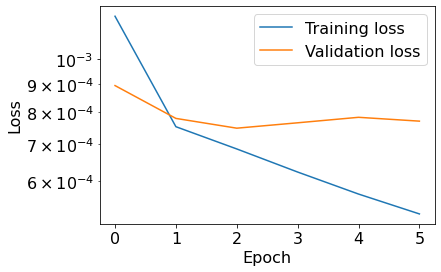

In [ ]:
import shutil

n_max, nhyp = get_sim_pars(nndatafilename)

# Вызовы построения и тренировки нейросети
datadir_Model = datadir + os.sep + 'Model'
#datadir_Graph = datadir + os.sep + 'Graph'
model_path = datadir_Model + os.sep + f'{mode}_phibins{nBins[0]}_thetabins{nBins[1]}_timebins{nBins[2]}_noise{noisefreqpersqmm:.0f}_gate{timeGate}ns_hlayers{hlayers}_tcor_model'.replace(', ','-')

nndata_dtypes, nndata_shapes = get_nndata_format(nndatafilename)

model = None
if restoreModel:
  try:
    print(f'Restoring model from path {model_path}...')
    with strategy.scope():
      model = tf.keras.models.load_model(model_path)
    assert(model.inputs[0].shape[1] == nndata_shapes[0][0])
  except:
    print('Failed to restore saved model!')
    if not fitModel:
      raise ValueError('Can not use unitialized model for prediction!')
#if model is None:
#  model = build_model(nndata_shapes[0], mode, hlayers, nhyp=nhyp)
#model.summary()

test_data, test_labels = load_nndata(nndatafilename, 'test')
test_labels = beta_to_feature(test_labels)
print(f' {test_data.shape[0]} events for validation and testing')

if fitModel:
  stopCallback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-8, patience=3, restore_best_weights=True)
  #tbCallback = tf.keras.callbacks.TensorBoard(log_dir=datadir_Graph, histogram_freq=1, write_graph=True, write_images=False)

  train_data, train_labels = load_nndata(nndatafilename, 'train')
  train_data, train_labels = train_data.to_numpy(), train_labels.to_numpy()
  train_labels = beta_to_feature(train_labels)
  print(f' {train_data.shape[0]} events for training')

  bufferSize = train_data.shape[0]
  trainStepsPerEpoch = train_data.shape[0]//batchSize
  testStepsPerEpoch = test_data.shape[0]//batchSize

  if mode=='beta':
    train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels, train_labels)).repeat().batch(batchSize, True)
    test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels, test_labels)).repeat().batch(batchSize, True)
  else:
    train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels)).repeat().batch(batchSize, True)
    test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels)).repeat().batch(batchSize, True)

  del train_data, train_labels

  print(f'Fitting model for at maximum {maxepochs} epochs...')
  for trainStepsPerEpoch in [500, 1000, 2000, 4000, 8000]:
    trainEvents = trainStepsPerEpoch*batchSize
    print(f'Train the model on {trainEvents} events')
    model = build_model(nndata_shapes[0], mode, hlayers, nhyp=nhyp)
    model.summary()
    history = model.fit(train_dataset, epochs=maxepochs,
                        validation_data=test_dataset,
                        callbacks=[stopCallback], #, tbCallback
                        steps_per_epoch=trainStepsPerEpoch,
                        validation_steps=testStepsPerEpoch)

    last_epoch = len(history.history['loss'])
    print("Last epoch number:", last_epoch)
    model_path = datadir_Model + os.sep + f'{mode}_phibins{nBins[0]}_thetabins{nBins[1]}_timebins{nBins[2]}_noise{noisefreqpersqmm:.0f}_gate{timeGate}ns_hlayers{hlayers}_train{trainEvents}_tcor_model'.replace(', ','-')
    model.save(model_path)

  plt.plot(history.history['loss'], '-', label='Training loss')
  plt.plot(history.history['val_loss'], '-', label='Validation loss')
  ymax = 1.1*max(*history.history['loss'],*history.history['val_loss'])
  plt.semilogy()
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
    
  del train_dataset, test_dataset

Evaluate model on 263846 events
8246/8246 - 12s - loss: 0.0019 - mse: 0.0019
Evaluation took 12.53 seconds
Prediction took 7.13 seconds
Systematic shift of beta w.r.t. MC truth: 0.000132
Standard deviation of beta residuals: 0.0021
Minimum standard deviation among theta_p-beta bins: 0.0006670307364107968


/mntDrive/My Drive/FARICH/Reconstruction/NN/farichnnlib.py:1000: LogWarning: x is really small return 0
  m.migrad() # fit
/mntDrive/My Drive/FARICH/Reconstruction/NN/farichnnlib.py:1000: LogWarning: x is really small return 0
  m.migrad() # fit
/mntDrive/My Drive/FARICH/Reconstruction/NN/farichnnlib.py:1000: LogWarning: x is really small return 0
  m.migrad() # fit
/mntDrive/My Drive/FARICH/Reconstruction/NN/farichnnlib.py:1000: LogWarning: x is really small return 0
  m.migrad() # fit
/mntDrive/My Drive/FARICH/Reconstruction/NN/farichnnlib.py:1000: LogWarning: x is really small return 0
  m.migrad() # fit
/mntDrive/My Drive/FARICH/Reconstruction/NN/farichnnlib.py:1000: LogWarning: x is really small return 0
  m.migrad() # fit
/mntDrive/My Drive/FARICH/Reconstruction/NN/farichnnlib.py:1000: LogWarning: x is really small return 0
  m.migrad() # fit
/mntDrive/My Drive/FARICH/Reconstruction/NN/farichnnlib.py:1000: LogWarning: x is really small return 0
  m.migrad() # fit
/mntDrive/My Dri

Minimum fitted gaussian sigma among theta_p-beta bins: 0.00047683532588911056


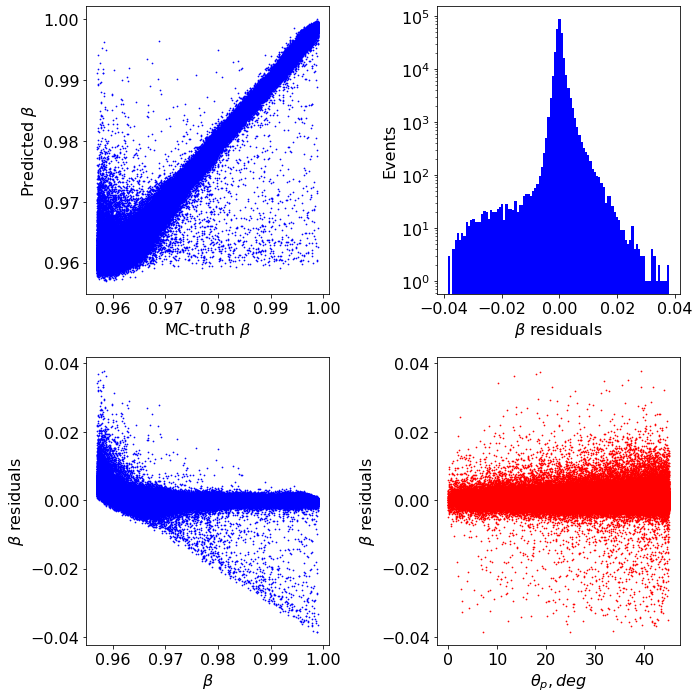

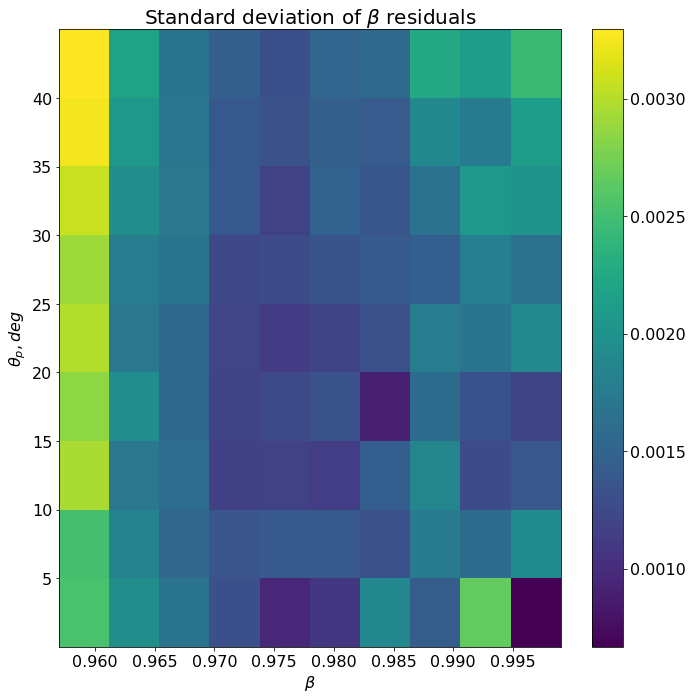

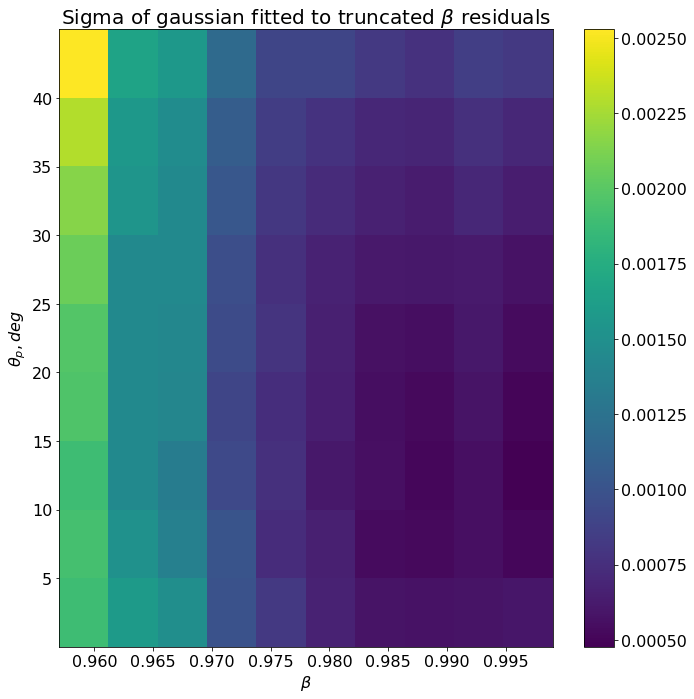

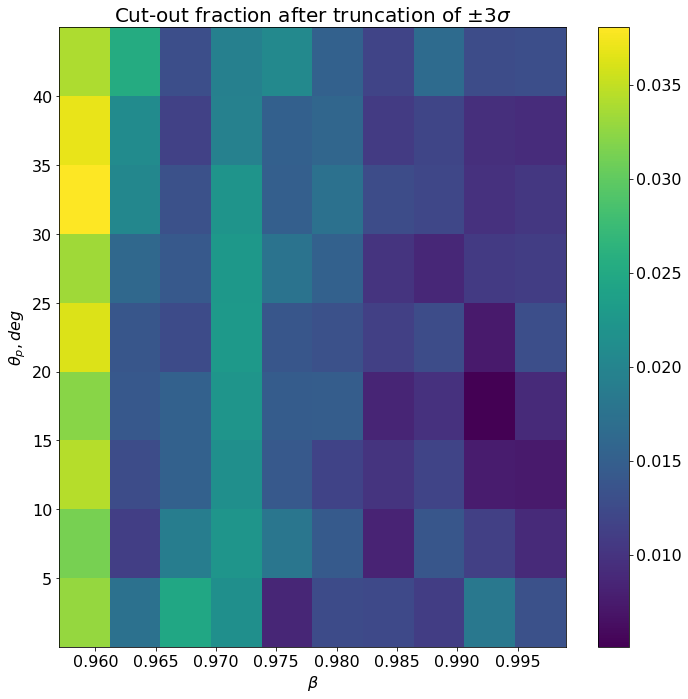

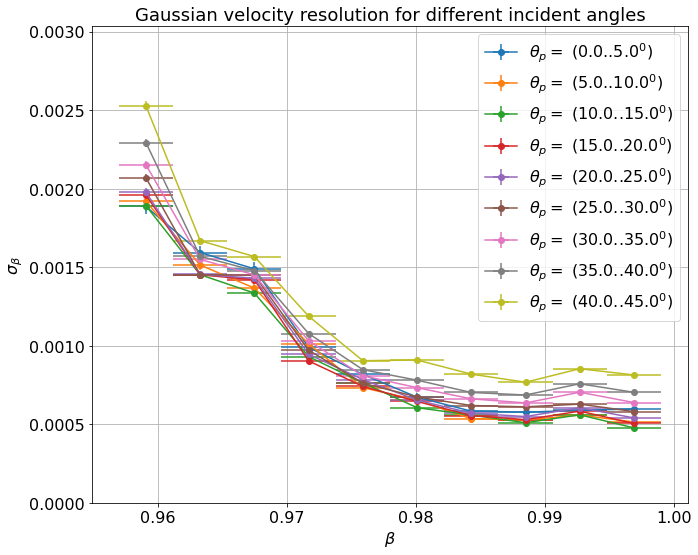

In [ ]:
# Оценка работы нейросети на проверочных данных
metric, prediction = evaluate_model(test_data, test_labels, model, mode, feature_to_beta, datadir, True)

In [ ]:
def shape(x, N, mean, sigma, c):
  return N * gaussian(x, mean, sigma) + c

def evalSigmaBeta(nndatafilename, model_path, transfunc, nbetapnts=10, theta_min=0, theta_max=10, draw=False):
  test_data, test_labels = load_nndata(nndatafilename, 'test')

  with strategy.scope():
    print(f'Restoring model from path {model_path}...')
    model = tf.keras.models.load_model(model_path)
    print(f'Predicting beta values...')
    prediction = model.predict(test_data).flatten()

  # Break up data into bins on beta and theta
  if 'rawbeta' in nndatafilename:
    betas = test_labels
  else:
    betas = transfunc(test_labels)
  beta_residual = transfunc(prediction) - betas
  thetas = test_data['theta_p_norm'].values.flatten()*90 # градусы
  beta_min, beta_max = betas.min(), betas.max()+1e-5
  theta_mask = (thetas>=theta_min) & (thetas<theta_max)
  betas, beta_residual = betas[theta_mask], beta_residual[theta_mask]
  beta_pnt = beta_min + (beta_max-beta_min) * (np.floor(nbetapnts * (betas-beta_min) / (beta_max-beta_min)) + 0.5) / nbetapnts
  resdfgrp = pd.DataFrame({'beta_pnt': beta_pnt, 'residual': beta_residual}, dtype=np.float64).groupby('beta_pnt')

  beta_set = np.zeros(nbetapnts)
  sigbeta = np.zeros(nbetapnts)
  sigbeta_error = np.zeros(nbetapnts)

  if draw:
    plt.figure(figsize=(12,nbetapnts*3))
  isp = 0
  for b, data in resdfgrp:
    series = data['residual']
    allEntries = series.size
    for i in range(2):
      mean, sd = series.mean(), series.std()
      q1, q2 = mean-3*sd, mean+3*sd
      series = series[(q1<series)&(series<q2)]
    cutoutfrac = series.size/allEntries

#    blh = BinnedLH(shape, cutseries, bins=100, bound=(q1,q2))
#    m = Minuit(blh, N=1, mean=cutseries.mean(), sigma=cutseries.std(), c=1, print_level=0)
    blh = BinnedLH(gaussian, series, bins=100, bound=(q1,q2))
    m = Minuit(blh, mean=series.mean(), sigma=series.std(), print_level=0)
    m.errordef = Minuit.LIKELIHOOD

    r = m.migrad() # fit

    #print(r)

    beta_set[isp] = b
    sigbeta[isp] = m.values['sigma']
    sigbeta_error[isp] = m.errors['sigma']

    if draw:
      ax = plt.subplot((nbetapnts+1)//2, 2, isp+1)
      blh.draw(m)
      plt.semilogy()
      plt.title(fr'$\beta$={beta_set[isp]:6.4f}, $\theta_p$={theta_min}..{theta_max} ')
      plt.text(0.5, 0.4, f'Cut-out fraction: {cutoutfrac*100:.1f}%', ha="center", va="center", transform=ax.transAxes)
      plt.tight_layout()
    isp += 1

  return beta_set, sigbeta, sigbeta_error

In [ ]:

nbetapnts = 10
suffixes = [f'_train{64000*2**n}' for n in range(5)]
labels = [f'{64*2**n}k training events' for n in range(5)]
nplots = len(suffixes)
betas = np.zeros((nbetapnts, nplots))
sigbetas = np.zeros((nbetapnts, nplots))
sigbeta_errors = np.zeros((nbetapnts, nplots))

# углы падения от 0^0 до 10^0
for i in range(nplots):
  nndatafilename = datadir + os.sep + 'beta_phibins5_thetabins20_timebins5_noise1000000_gate5ns_tcor_nndata.h5'
  model_path = datadir + os.sep + 'Model' + os.sep + 'beta_phibins5_thetabins20_timebins5_noise1000000_gate5ns_hlayers(200-100-50-20)' + suffixes[i] + '_tcor_model'
  betas[:,i], sigbetas[:,i], sigbeta_errors[:,i] = evalSigmaBeta(nndatafilename, model_path, feature_to_beta, nbetapnts, theta_min=0, theta_max=10, draw=True)

plt.figure(figsize=(10,8))
for i in range(nplots): 
  dbeta = (betas[1,i] - betas[0,i]) / np.sqrt(12)
  plt.errorbar(betas[:,i], sigbetas[:,i], xerr=dbeta, yerr=sigbeta_errors[:,i], fmt='-o', label=labels[i])
plt.xlabel(r'$\beta$', fontsize=16)
plt.ylabel(r'$\sigma_\beta$', fontsize=16)
plt.title(rf'Gaussian velocity resolution, DCR=1Mcps/mm$^2$, $\theta_p<10^0$, 3d bins (5-20-5)')
plt.ylim(0, 1.2*sigbetas.max())
plt.grid()
plt.legend(fontsize=16)
plt.tight_layout()
plt.savefig(datadir + os.sep + f'beta_gaus_res_theta0-10deg_dcr1Mcps_3dbinning_vartrainevents.png')

# углы падения от 35^0 до 45^0
for i in range(nplots):
  model_path = datadir + os.sep + 'Model' + os.sep + 'beta_phibins5_thetabins20_timebins5_noise1000000_gate5ns_hlayers(200-100-50-20)' + suffixes[i] + '_tcor_model'
  betas[:,i], sigbetas[:,i], sigbeta_errors[:,i] = evalSigmaBeta(nndatafilename, model_path, feature_to_beta, nbetapnts, theta_min=0, theta_max=10, draw=True)

plt.figure(figsize=(10,8))
for i in range(nplots): 
  dbeta = (betas[1,i] - betas[0,i]) / np.sqrt(12)
  plt.errorbar(betas[:,i], sigbetas[:,i], xerr=dbeta, yerr=sigbeta_errors[:,i], fmt='-o', label=labels[i])
plt.xlabel(r'$\beta$', fontsize=16)
plt.ylabel(r'$\sigma_\beta$', fontsize=16)
plt.title(rf'Gaussian velocity resolution, DCR=1Mcps/mm$^2$, $\theta_p=35^0..45^0$, 3d bins (5-20-5)')
plt.ylim(0, 1.2*sigbetas.max())
plt.grid()
plt.legend(fontsize=16)
plt.tight_layout()
plt.savefig(datadir + os.sep + f'beta_gaus_res_theta35-45deg_dcr1Mcps_3dbinning_vartrainevents.png')


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
'''
nbetapnts = 10
suffixes = ('', '_cut')
labels = ('Partial events', 'Whole only events', 'Whole only events data & partial events NN', 'Partial events data & whole only events NN' )
nplots = len(suffixes)+2
betas = np.zeros((nbetapnts, nplots))
sigbetas = np.zeros((nbetapnts, nplots))
sigbeta_errors = np.zeros((nbetapnts, nplots))

for i in range(nplots-2):
  nndatafilename = datadir + os.sep + f'{mode}_noise{noisefreqpersqmm}' + suffixes[i] + '_tcor_nndata.h5'
  model_path = datadir + os.sep + 'Model' + os.sep + f'{mode}_noise{noisefreqpersqmm}' + suffixes[i] + '_tcor_model'
  betas[:,i], sigbetas[:,i], sigbeta_errors[:,i] = evalSigmaBeta(nndatafilename, model_path, nbetapnts, theta_min=0, theta_max=10, draw=True)

nndatafilename = datadir + os.sep + f'{mode}_noise{noisefreqpersqmm}_cut_tcor_nndata.h5'
model_path = datadir + os.sep + 'Model' + os.sep + f'{mode}_noise{noisefreqpersqmm}_tcor_model'
betas[:,2], sigbetas[:,2], sigbeta_errors[:,2] = evalSigmaBeta(nndatafilename, model_path, nbetapnts, theta_min=0, theta_max=10, draw=True)

nndatafilename = datadir + os.sep + f'{mode}_noise{noisefreqpersqmm}_tcor_nndata.h5'
model_path = datadir + os.sep + 'Model' + os.sep + f'{mode}_noise{noisefreqpersqmm}_cut_tcor_model'
betas[:,3], sigbetas[:,3], sigbeta_errors[:,3] = evalSigmaBeta(nndatafilename, model_path, nbetapnts, theta_min=0, theta_max=10, draw=True)

plt.figure(figsize=(10,8))
for i in range(nplots):
  dbeta = (betas[1,i] - betas[0,i]) / np.sqrt(12)
  plt.errorbar(betas[:,i], sigbetas[:,i], xerr=dbeta, yerr=sigbeta_errors[:,i], fmt='-o', label=labels[i])
plt.xlabel(r'$\beta$', fontsize=16)
plt.ylabel(r'$\sigma_\beta$', fontsize=16)
plt.title(rf'Gaussian velocity resolution, DCR={noisefreqpersqmm/1e3:.0f}kcps, $\theta<10^0$', fontsize=18)
plt.ylim(0, 1.2*sigbetas.max())
plt.legend(fontsize=16)
plt.savefig(datadir + os.sep + f'beta_gaus_res_theta0-10deg_dcr{noisefreqpersqmm/1e3:.0f}kcps_cutevents.png')
'''

In [ ]:
'''
nbetapnts = 10
fsuffixes = ['_rawbeta'] * 5 + ['_rawbeta_double']
msuffixes = ('_betan105', '_betan11', '_betan15', '_betan5', '_rawbeta', '_rawbeta_double')
labels = ('Transformed beta with n=1.05', 'Transformed beta with n=1.10', 'Transformed beta with n=1.50', 'Transformed beta with n=5.0', 'Raw beta', 'Raw beta with double values')
transfuncs = (feature_to_beta_n105, feature_to_beta_n11, feature_to_beta_n15, feature_to_beta_n5, equivtrans, equivtrans)
nplots = len(msuffixes)
betas = np.zeros((nbetapnts, nplots))
sigbetas = np.zeros((nbetapnts, nplots))
sigbeta_errors = np.zeros((nbetapnts, nplots))

for i in range(nplots):
  nndatafilename = datadir + os.sep + f'{mode}_noise{noisefreqpersqmm}' + fsuffixes[i] + '_tcor_nndata.h5'
  model_path = datadir + os.sep + 'Model' + os.sep + f'{mode}_noise{noisefreqpersqmm}' + msuffixes[i] + '_tcor_model'
  betas[:,i], sigbetas[:,i], sigbeta_errors[:,i] = evalSigmaBeta(nndatafilename, model_path, transfuncs[i], nbetapnts, theta_min=0, theta_max=10, draw=True)

plt.figure(figsize=(10,8))
for i in range(nplots):
  dbeta = (betas[1,i] - betas[0,i]) / np.sqrt(12)
  plt.errorbar(betas[:,i], sigbetas[:,i], xerr=dbeta, yerr=sigbeta_errors[:,i], fmt='-o', label=labels[i])
plt.xlabel(r'$\beta$', fontsize=16)
plt.ylabel(r'$\sigma_\beta$', fontsize=16)
plt.title(rf'Gaussian velocity resolution, DCR={noisefreqpersqmm/1e3:.0f}kcps, $\theta<10^0$', fontsize=18)
plt.ylim(0, 1.2*sigbetas.max())
plt.legend(fontsize=16)
plt.savefig(datadir + os.sep + f'beta_gaus_res_theta0-10deg_dcr{noisefreqpersqmm/1e3:.0f}kcps_betatransformopts.png')
'''

In [ ]:
'''
nbetapnts = 10
suffixes = ('_phibins5_thetabins15_timebins5_noise1000000', '_phibins5_thetabins20_timebins1_noise1000000', 
            '_phibins5_thetabins20_timebins2_noise1000000', '_phibins3_thetabins20_timebins5_noise1000000_gate5ns', 
            '_phibins5_thetabins20_timebins5_noise1000000', 
            '_phibins10_thetabins20_timebins5_noise1000000', '_phibins5_thetabins30_timebins1_noise1000000', 
            '_phibins10_thetabins30_timebins1_noise1000000', '_phibins5_thetabins30_timebins5_noise1000000')
labels = (r'3d bins: $\phi_c$ - 5, $\theta_c$ - 15, time - 5', r'3d bins: $\phi_c$ - 5, $\theta_c$ - 20, time - 1', 
          r'3d bins: $\phi_c$ - 5, $\theta_c$ - 20, time - 2', r'3d bins: $\phi_c$ - 3, $\theta_c$ - 20, time - 5', 
          r'3d bins: $\phi_c$ - 5, $\theta_c$ - 20, time - 5', 
          r'3d bins: $\phi_c$ - 10, $\theta_c$ - 20, time - 5 (trained on 300k events)', 
          r'3d bins: $\phi_c$ - 5, $\theta_c$ - 30, time - 1', r'3d bins: $\phi_c$ - 10, $\theta_c$ - 30, time - 1',
          r'3d bins: $\phi_c$ - 5, $\theta_c$ - 30, time - 5 (trained on 500k events)')
nplots = len(suffixes)
betas = np.zeros((nbetapnts, nplots))
sigbetas = np.zeros((nbetapnts, nplots))
sigbeta_errors = np.zeros((nbetapnts, nplots))

for i in range(nplots):
  nndatafilename = datadir + os.sep + mode + suffixes[i] + '_tcor_nndata.h5'
  model_path = datadir + os.sep + 'Model' + os.sep + mode + suffixes[i] + '_hlayers(200-100-50-20)_tcor_model'
  betas[:,i], sigbetas[:,i], sigbeta_errors[:,i] = evalSigmaBeta(nndatafilename, model_path, feature_to_beta, nbetapnts, theta_min=0, theta_max=10, draw=True)


plt.figure(figsize=(10,8))
for i in range(nplots): 
  dbeta = (betas[1,i] - betas[0,i]) / np.sqrt(12)
  plt.errorbar(betas[:,i], sigbetas[:,i], xerr=dbeta, yerr=sigbeta_errors[:,i], fmt='-o', label=labels[i])
plt.xlabel(r'$\beta$', fontsize=16)
plt.ylabel(r'$\sigma_\beta$', fontsize=16)
plt.title(rf'Gaussian velocity resolution, DCR=1Mcps/mm$^2$, $\theta_p<10^0$', fontsize=18)
plt.ylim(0, 1.2*sigbetas.max())
plt.grid()
plt.legend(fontsize=16)
plt.tight_layout()
plt.savefig(datadir + os.sep + f'beta_gaus_res_theta0-10deg_dcr1Mcps_var3dbinning.png')
'''

In [ ]:
'''
nbetapnts = 10
suffixes = ('_phibins5_thetabins20_timebins5_noise1000000', '_phibins5_thetabins20_timebins5_noise1000000_gate5ns', 
            '_phibins5_thetabins20_timebins1_gate1ns_noise1000000', '_phibins5_thetabins20_timebins5_gate1ns_noise1000000')
labels = (r'3d bins: $\phi_c$ - 5, $\theta_c$ - 20, time - 5, implicit gate 5 ns', r'3d bins: $\phi_c$ - 5, $\theta_c$ - 20, time - 5, explicit gate 5 ns', 
          r'3d bins: $\phi_c$ - 5, $\theta_c$ - 20, time - 1, gate 1 ns', r'3d bins: $\phi_c$ - 5, $\theta_c$ - 20, time - 5, gate 1 ns')
nplots = len(suffixes)
betas = np.zeros((nbetapnts, nplots))
sigbetas = np.zeros((nbetapnts, nplots))
sigbeta_errors = np.zeros((nbetapnts, nplots))

# углы падения от 0^0 до 10^0
for i in range(nplots):
  nndatafilename = datadir + os.sep + mode + suffixes[i] + '_tcor_nndata.h5'
  model_path = datadir + os.sep + 'Model' + os.sep + mode + suffixes[i] + '_hlayers(200-100-50-20)_tcor_model'
  betas[:,i], sigbetas[:,i], sigbeta_errors[:,i] = evalSigmaBeta(nndatafilename, model_path, feature_to_beta, nbetapnts, theta_min=0, theta_max=10, draw=True)

plt.figure(figsize=(10,8))
for i in range(nplots): 
  dbeta = (betas[1,i] - betas[0,i]) / np.sqrt(12)
  plt.errorbar(betas[:,i], sigbetas[:,i], xerr=dbeta, yerr=sigbeta_errors[:,i], fmt='-o', label=labels[i])
plt.xlabel(r'$\beta$', fontsize=16)
plt.ylabel(r'$\sigma_\beta$', fontsize=16)
plt.title(rf'Gaussian velocity resolution, DCR=1Mcps/mm$^2$, $\theta_p<10^0$', fontsize=18)
plt.ylim(0, 1.2*sigbetas.max())
plt.grid()
plt.legend(fontsize=16)
plt.tight_layout()
plt.savefig(datadir + os.sep + f'beta_gaus_res_theta0-10deg_dcr1Mcps_3dbinning_vargate.png')

# углы падения от 35^0 до 45^0
for i in range(nplots):
  nndatafilename = datadir + os.sep + mode + suffixes[i] + '_tcor_nndata.h5'
  model_path = datadir + os.sep + 'Model' + os.sep + mode + suffixes[i] + '_hlayers(200-100-50-20)_tcor_model'
  betas[:,i], sigbetas[:,i], sigbeta_errors[:,i] = evalSigmaBeta(nndatafilename, model_path, feature_to_beta, nbetapnts, theta_min=0, theta_max=10, draw=True)

plt.figure(figsize=(10,8))
for i in range(nplots): 
  dbeta = (betas[1,i] - betas[0,i]) / np.sqrt(12)
  plt.errorbar(betas[:,i], sigbetas[:,i], xerr=dbeta, yerr=sigbeta_errors[:,i], fmt='-o', label=labels[i])
plt.xlabel(r'$\beta$', fontsize=16)
plt.ylabel(r'$\sigma_\beta$', fontsize=16)
plt.title(rf'Gaussian velocity resolution, DCR=1Mcps/mm$^2$, $\theta_p=35^0..45^0$', fontsize=18)
plt.ylim(0, 1.2*sigbetas.max())
plt.grid()
plt.legend(fontsize=16)
plt.tight_layout()
plt.savefig(datadir + os.sep + f'beta_gaus_res_theta35-45deg_dcr1Mcps_3dbinning_vargate.png')
'''

In [ ]:
'''
nbetapnts = 10
suffixes = ('_phibins5_thetabins20_timebins5_noise0', '_phibins5_thetabins20_timebins5_noise50000', '_phibins5_thetabins20_timebins5_noise1000000')
labels = ('DCR = 0 cps', 'DCR = 50 kcps', 'DCR = 1 Mcps')
nplots = len(suffixes)

# углы падения от 0^0 до 10^0
betas = np.zeros((nbetapnts, nplots))
sigbetas = np.zeros((nbetapnts, nplots))
sigbeta_errors = np.zeros((nbetapnts, nplots))

for i in range(nplots):
  nndatafilename = datadir + os.sep + mode + suffixes[i] + '_tcor_nndata.h5'
  model_path = datadir + os.sep + 'Model' + os.sep + mode + suffixes[i] + '_hlayers(200-100-50-20)_tcor_model'
  betas[:,i], sigbetas[:,i], sigbeta_errors[:,i] = evalSigmaBeta(nndatafilename, model_path, feature_to_beta, nbetapnts, theta_min=0, theta_max=10, draw=True)


plt.figure(figsize=(10,8))
for i in range(nplots): 
  dbeta = (betas[1,i] - betas[0,i]) / np.sqrt(12)
  plt.errorbar(betas[:,i], sigbetas[:,i], xerr=dbeta, yerr=sigbeta_errors[:,i], fmt='-o', label=labels[i])
plt.xlabel(r'$\beta$', fontsize=16)
plt.ylabel(r'$\sigma_\beta$', fontsize=16)
plt.title(rf'Gaussian velocity resolution, $\theta_p<10^0$, 3d binning (5,20,5)', fontsize=18)
plt.ylim(0, 1.2*sigbetas.max())
plt.legend(fontsize=16)
plt.grid()
plt.savefig(datadir + os.sep + f'beta_gaus_res_theta0-10deg_3dbinning_vardcr.png')

# углы падения от 35^0 до 45^0
for i in range(nplots):
  nndatafilename = datadir + os.sep + mode + suffixes[i] + '_tcor_nndata.h5'
  model_path = datadir + os.sep + 'Model' + os.sep + mode + suffixes[i] + '_hlayers(200-100-50-20)_tcor_model'
  betas[:,i], sigbetas[:,i], sigbeta_errors[:,i] = evalSigmaBeta(nndatafilename, model_path, feature_to_beta, nbetapnts, theta_min=35, theta_max=45, draw=True)

plt.figure(figsize=(10,8))
for i in range(nplots): 
  dbeta = (betas[1,i] - betas[0,i]) / np.sqrt(12)
  plt.errorbar(betas[:,i], sigbetas[:,i], xerr=dbeta, yerr=sigbeta_errors[:,i], fmt='-o', label=labels[i])
plt.xlabel(r'$\beta$', fontsize=16)
plt.ylabel(r'$\sigma_\beta$', fontsize=16)
plt.title(rf'Gaussian velocity resolution, $\theta_p=35^0..45^0$, 3d binning (5,20,5)', fontsize=18)
plt.ylim(0, 1.2*sigbetas.max())
plt.legend(fontsize=16)
plt.grid()
plt.savefig(datadir + os.sep + f'beta_gaus_res_theta35-45deg_3dbinning_vardcr.png')
''

In [ ]:
'''
nbetapnts = 10
suffixes = ('_hlayers(100-50-25)', '_hlayers(200-100-50-20)', '_hlayers(500-250-125-25)', '_hlayers(1000-300-100)', '_hlayers(1000-500-200-50)')
labels = [f'NN hidden layers: {hl[9:-1]}' for hl in suffixes]
nplots = len(suffixes)

# углы падения от 0^0 до 10^0
betas = np.zeros((nbetapnts, nplots))
sigbetas = np.zeros((nbetapnts, nplots))
sigbeta_errors = np.zeros((nbetapnts, nplots))

for i in range(nplots):
  nndatafilename = datadir + os.sep + mode + '_phibins5_thetabins20_timebins5_noise1000000_tcor_nndata.h5'
  model_path = datadir + os.sep + 'Model' + os.sep + mode + '_phibins5_thetabins20_timebins5_noise1000000' + suffixes[i] + '_tcor_model'
  betas[:,i], sigbetas[:,i], sigbeta_errors[:,i] = evalSigmaBeta(nndatafilename, model_path, feature_to_beta, nbetapnts, theta_min=0, theta_max=10, draw=True)


plt.figure(figsize=(10,8))
for i in range(nplots): 
  dbeta = (betas[1,i] - betas[0,i]) / np.sqrt(12)
  plt.errorbar(betas[:,i], sigbetas[:,i], xerr=dbeta, yerr=sigbeta_errors[:,i], fmt='-o', label=labels[i])
plt.xlabel(r'$\beta$', fontsize=16)
plt.ylabel(r'$\sigma_\beta$', fontsize=16)
plt.title(rf'Gaussian velocity resolution, $\theta_p<10^0$, DCR=1Mcps/mm$^2$, 3d binning (5,20,5)', fontsize=18)
plt.ylim(0, 1.2*sigbetas.max())
plt.legend(fontsize=16)
plt.grid()
plt.savefig(datadir + os.sep + f'beta_gaus_res_theta0-10deg_3dbinning_hlayersvars.png')

# углы падения от 35^0 до 45^0
for i in range(nplots):
  nndatafilename = datadir + os.sep + mode + '_phibins5_thetabins20_timebins5_noise1000000_tcor_nndata.h5'
  model_path = datadir + os.sep + 'Model' + os.sep + mode + '_phibins5_thetabins20_timebins5_noise1000000' + suffixes[i] + '_tcor_model'
  betas[:,i], sigbetas[:,i], sigbeta_errors[:,i] = evalSigmaBeta(nndatafilename, model_path, feature_to_beta, nbetapnts, theta_min=35, theta_max=45, draw=True)

plt.figure(figsize=(10,8))
for i in range(nplots): 
  dbeta = (betas[1,i] - betas[0,i]) / np.sqrt(12)
  plt.errorbar(betas[:,i], sigbetas[:,i], xerr=dbeta, yerr=sigbeta_errors[:,i], fmt='-o', label=labels[i])
plt.xlabel(r'$\beta$', fontsize=16)
plt.ylabel(r'$\sigma_\beta$', fontsize=16)
plt.title(rf'Gaussian velocity resolution, $\theta_p=35^0..45^0$, DCR=1Mcps/mm$^2$, 3d binning (5,20,5)', fontsize=18)
plt.ylim(0, 1.2*sigbetas.max())
plt.legend(fontsize=16)
plt.grid()
plt.savefig(datadir + os.sep + f'beta_gaus_res_theta35-45deg_3dbinning_hlayersvars.png')
'''